In [1]:
import json
import pickle
import requests
import warnings
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

import dgl
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
warnings.filterwarnings('ignore')
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Pure Code

In [2]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

efficientnet.eval().to(device)

Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [3]:
uris = [
    'http://images.cocodataset.org/test-stuff2017/000000024309.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000028117.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000006149.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000004954.jpg',
]

batch = torch.cat(
    [utils.prepare_input_from_uri(uri) for uri in uris]
).to(device)

In [4]:
with torch.no_grad():
    output = torch.nn.functional.softmax(efficientnet(batch), dim=1)
    
results = utils.pick_n_best(predictions=output, n=5)

sample 0: [('laptop, laptop computer', '49.9%'), ('notebook, notebook computer', '36.1%'), ('desk', '3.7%'), ('mouse, computer mouse', '0.5%'), ('space bar', '0.5%')]
sample 1: [('mashed potato', '86.9%'), ('meat loaf, meatloaf', '5.2%'), ('broccoli', '1.9%'), ('plate', '0.3%'), ('guacamole', '0.1%')]
sample 2: [('racket, racquet', '55.8%'), ('tennis ball', '8.4%'), ('ping-pong ball', '2.6%'), ('golf ball', '0.6%'), ('baseball', '0.6%')]
sample 3: [('kelpie', '52.8%'), ('malinois', '4.1%'), ('groenendael', '3.0%'), ('schipperke', '3.0%'), ('Scottish deerhound, deerhound', '2.6%')]


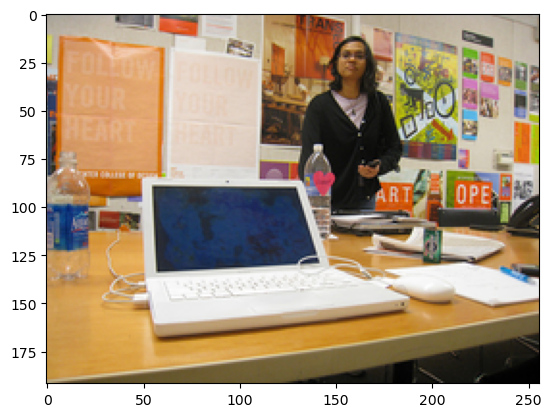

[('laptop, laptop computer', '49.9%'), ('notebook, notebook computer', '36.1%'), ('desk', '3.7%'), ('mouse, computer mouse', '0.5%'), ('space bar', '0.5%')]


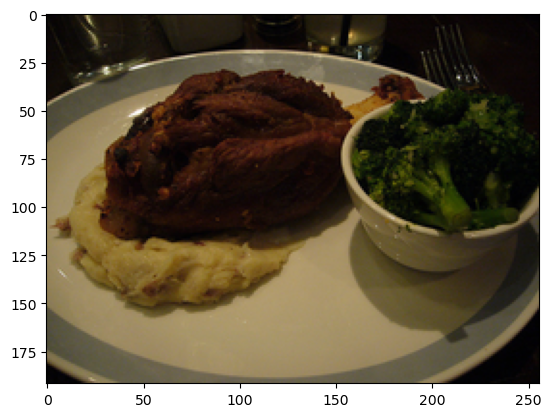

[('mashed potato', '86.9%'), ('meat loaf, meatloaf', '5.2%'), ('broccoli', '1.9%'), ('plate', '0.3%'), ('guacamole', '0.1%')]


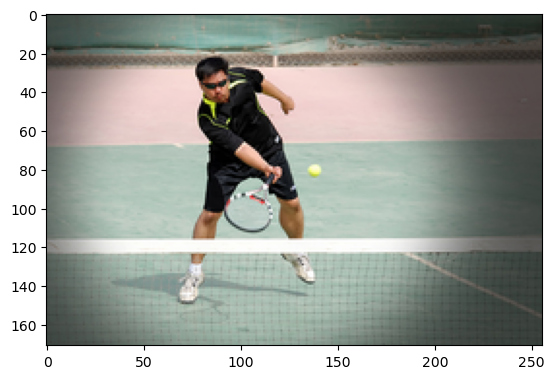

[('racket, racquet', '55.8%'), ('tennis ball', '8.4%'), ('ping-pong ball', '2.6%'), ('golf ball', '0.6%'), ('baseball', '0.6%')]


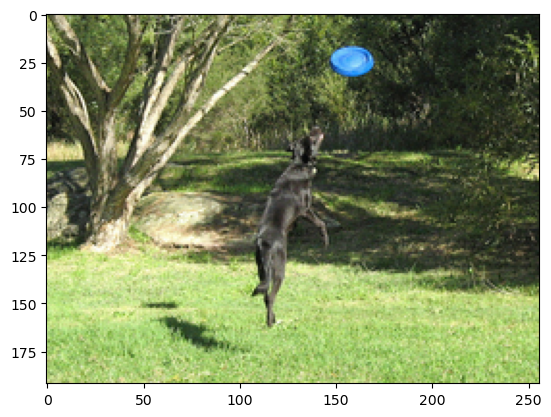

[('kelpie', '52.8%'), ('malinois', '4.1%'), ('groenendael', '3.0%'), ('schipperke', '3.0%'), ('Scottish deerhound, deerhound', '2.6%')]


In [5]:
for uri, result in zip(uris, results):
    img = Image.open(requests.get(uri, stream=True).raw)
    img.thumbnail((256,256), Image.ANTIALIAS)
    plt.imshow(img)
    plt.show()
    print(result)

## My Code

In [9]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

efficientnet.eval().to(device)

efficientnet.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten()
)

efficientnet

Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [10]:
uris = [
    'http://images.cocodataset.org/test-stuff2017/000000024309.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000028117.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000006149.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000004954.jpg',
]

batch = torch.cat([utils.prepare_input_from_uri(uri) for uri in uris]).to(device)

In [11]:
with torch.no_grad():
    output = efficientnet(batch)

print(output.shape)
print(output)

torch.Size([4, 1280])
tensor([[ 0.3523,  0.0027,  0.1278,  ..., -0.1113,  0.4703,  0.0718],
        [-0.1490,  0.0989,  1.3026,  ..., -0.1219,  0.1604,  0.3010],
        [-0.0994,  0.2853, -0.0247,  ..., -0.1791, -0.1648, -0.1583],
        [-0.1477,  0.1425, -0.1735,  ..., -0.0712,  1.1080, -0.0454]],
       device='cuda:0')


## Download Birdsnap

In [12]:
!wget http://thomasberg.org/datasets/birdsnap/1.1/birdsnap.tgz

--2022-12-31 20:38:41--  http://thomasberg.org/datasets/birdsnap/1.1/birdsnap.tgz
Resolving thomasberg.org (thomasberg.org)... 198.199.111.112
Connecting to thomasberg.org (thomasberg.org)|198.199.111.112|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5585091 (5.3M) [application/octet-stream]
Saving to: ‘birdsnap.tgz’

birdsnap.tgz        100%[===================>]   5.33M  2.43MB/s    in 2.2s    

2022-12-31 20:38:44 (2.43 MB/s) - ‘birdsnap.tgz’ saved [5585091/5585091]



In [13]:
!tar -zxvf birdsnap.tgz

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
birdsnap/
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
birdsnap/all-ims
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
birdsnap/get_birdsnap.py
tar: Ignoring unknown extended header keyword 'SCHILY.dev'
tar: Ignoring unknown extended header keyword 'SCHILY.ino'
tar: Ignoring unknown extended header keyword 'SCHILY.nlink'
birdsnap/images.txt
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationti

In [1]:
%cd /media/extra_storage/anirban/birdsnap/

/media/extra_storage/anirban/birdsnap


In [ ]:
!python3 get_birdsnap.py

[2023-01-02 12:14:51] Starting.
[2023-01-02 12:14:51] Removing existing temp directory.
[2023-01-02 12:14:51] Reading images list from file images.txt...
[2023-01-02 12:14:51] 49829 images in list.
[2023-01-02 12:14:51] Start image 1 of 49829: Coopers_Hawk/0005.jpg
[2023-01-02 12:14:51] Already have the image and contents are correct.
[2023-01-02 12:14:51] Finished image 1 of 49829 with result ALREADY_OK.  Progress is NEW_OK:0, ALREADY_OK:1, DOWNLOAD_FAILED:0, SAVE_FAILED:0, MD5_FAILED:0, MYSTERY_FAILED:0.
[2023-01-02 12:14:51] Start image 2 of 49829: Coopers_Hawk/0057.jpg
[2023-01-02 12:14:51] Already have the image and contents are correct.
[2023-01-02 12:14:51] Finished image 2 of 49829 with result ALREADY_OK.  Progress is NEW_OK:0, ALREADY_OK:2, DOWNLOAD_FAILED:0, SAVE_FAILED:0, MD5_FAILED:0, MYSTERY_FAILED:0.
[2023-01-02 12:14:51] Start image 3 of 49829: Coopers_Hawk/0103.jpg
[2023-01-02 12:14:51] Already have the image and contents are correct.
[2023-01-02 12:14:51] Finished imag

In [1]:
!du -hs /media/extra_storage/anirban

66G	/media/extra_storage/anirban


In [2]:
!find /media/extra_storage/anirban -type f | wc -l

44290


## Preprocess Birdsnap

In [2]:
!ls -lrt "/media/extra_storage/anirban/birdsnap/download/images"

total 2000
drwxrwxr-x 2 anirban anirban 4096 Dec 31 20:53 Coopers_Hawk
drwxrwxr-x 2 anirban anirban 4096 Dec 31 20:54 Northern_Goshawk
drwxrwxr-x 2 anirban anirban 4096 Dec 31 20:56 Sharp_shinned_Hawk
drwxrwxr-x 2 anirban anirban 4096 Dec 31 20:57 Golden_Eagle
drwxrwxr-x 2 anirban anirban 4096 Dec 31 20:59 White_tailed_Hawk
drwxrwxr-x 2 anirban anirban 4096 Dec 31 21:01 Red_tailed_Hawk
drwxrwxr-x 2 anirban anirban 4096 Dec 31 21:03 Rough_legged_Hawk
drwxrwxr-x 2 anirban anirban 4096 Dec 31 21:04 Red_shouldered_Hawk
drwxrwxr-x 2 anirban anirban 4096 Dec 31 21:06 Broad_winged_Hawk
drwxrwxr-x 2 anirban anirban 4096 Dec 31 21:10 Ferruginous_Hawk
drwxrwxr-x 2 anirban anirban 4096 Dec 31 21:11 Swainsons_Hawk
drwxrwxr-x 2 anirban anirban 4096 Dec 31 21:13 Common_Black_Hawk
drwxrwxr-x 2 anirban anirban 4096 Dec 31 21:14 Northern_Harrier
drwxrwxr-x 2 anirban anirban 4096 Dec 31 21:16 Swallow_tailed_Kite
drwxrwxr-x 2 anirban anirban 4096 Dec 31 21:17 White_tailed_Kite
drwxrwxr-x 2 anirban anirba

In [3]:
!du -hs "/media/extra_storage/anirban/birdsnap/download/images"

65G	/media/extra_storage/anirban/birdsnap/download/images


In [4]:
data_transforms = transforms.Compose([
                        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                  ])

image_dataset = datasets.ImageFolder("/media/extra_storage/anirban/birdsnap/download/images", data_transforms)
dataloader = DataLoader(image_dataset, batch_size=64, shuffle=True, drop_last=True)

In [5]:
image_dataset.classes

['Acadian_Flycatcher',
 'Acorn_Woodpecker',
 'Alder_Flycatcher',
 'Allens_Hummingbird',
 'Altamira_Oriole',
 'American_Avocet',
 'American_Bittern',
 'American_Black_Duck',
 'American_Coot',
 'American_Crow',
 'American_Dipper',
 'American_Golden_Plover',
 'American_Goldfinch',
 'American_Kestrel',
 'American_Oystercatcher',
 'American_Pipit',
 'American_Redstart',
 'American_Robin',
 'American_Three_toed_Woodpecker',
 'American_Tree_Sparrow',
 'American_White_Pelican',
 'American_Wigeon',
 'American_Woodcock',
 'Anhinga',
 'Annas_Hummingbird',
 'Arctic_Tern',
 'Ash_throated_Flycatcher',
 'Audubons_Oriole',
 'Bairds_Sandpiper',
 'Bald_Eagle',
 'Baltimore_Oriole',
 'Band_tailed_Pigeon',
 'Barn_Swallow',
 'Barred_Owl',
 'Barrows_Goldeneye',
 'Bay_breasted_Warbler',
 'Bells_Vireo',
 'Belted_Kingfisher',
 'Bewicks_Wren',
 'Black_Guillemot',
 'Black_Oystercatcher',
 'Black_Phoebe',
 'Black_Rosy_Finch',
 'Black_Scoter',
 'Black_Skimmer',
 'Black_Tern',
 'Black_Turnstone',
 'Black_Vulture',
 

In [6]:
for d in dataloader:
    print(d)
    print(d[0].shape)
    break

[tensor([[[[-1.7583, -1.7754, -1.7240,  ...,  0.3652,  0.5022,  0.6221],
          [-1.0219, -1.3644, -1.2959,  ...,  0.3138,  0.3652,  0.5878],
          [-1.0390, -1.5357, -1.7583,  ...,  0.2967,  0.2282,  0.2282],
          ...,
          [ 0.6049,  0.6049,  0.6049,  ..., -1.4158, -1.3473, -1.2445],
          [ 0.5707,  0.5878,  0.6049,  ..., -1.4329, -1.3644, -1.2445],
          [ 0.5878,  0.6049,  0.6049,  ..., -1.4158, -1.3644, -1.2617]],

         [[-1.5805, -1.5455, -1.5280,  ...,  0.4328,  0.7654,  1.0105],
          [-0.7052, -1.0728, -1.0378,  ...,  0.5553,  0.6254,  0.9055],
          [-0.8452, -1.3529, -1.5805,  ...,  0.7304,  0.6604,  0.6078],
          ...,
          [ 1.2381,  1.2556,  1.2556,  ..., -1.5630, -1.4930, -1.4055],
          [ 1.2381,  1.2556,  1.2556,  ..., -1.5980, -1.5455, -1.4580],
          [ 1.2381,  1.2556,  1.2556,  ..., -1.5980, -1.5455, -1.4755]],

         [[-1.6127, -1.6127, -1.5779,  ..., -0.5495, -0.2010, -0.2358],
          [-1.1770, -1.2816, 

## Model and Inference

In [7]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
efficientnet.eval().to(device)

efficientnet.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten()
)

efficientnet

Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [8]:
emb = []
lab = []

for batch in tqdm(dataloader):
    data = batch[0].to(device)
    label = batch[1]
    out = efficientnet(data)
    emb.append(out.detach().cpu())
    lab.append(label)
    
embeddings = torch.cat(emb)
labels = torch.cat(lab)
print(embeddings)
print(labels)
print(embeddings.shape)
print(labels.shape)

  0%|          | 0/622 [00:00<?, ?it/s]

tensor([[ 0.1537,  0.1252, -0.0990,  ...,  0.1888,  0.3827,  0.2085],
        [ 0.2082,  0.3268, -0.0941,  ...,  0.0021,  0.0534, -0.0692],
        [-0.0261, -0.0238, -0.0273,  ..., -0.0930, -0.1632,  0.0012],
        ...,
        [ 0.1326,  0.1034, -0.1603,  ..., -0.0719,  0.4067,  0.3333],
        [ 0.1766, -0.1963,  0.0234,  ...,  0.3149,  0.3560,  1.1121],
        [-0.0772, -0.2314, -0.1143,  ..., -0.1476, -0.0209,  0.2798]])
tensor([457,  22,  16,  ..., 172,  13, 489])
torch.Size([39808, 1280])
torch.Size([39808])


In [43]:
data = {"embeddings" : embeddings, "labels" : labels}
with open('bird.pickle', 'wb') as f:
    pickle.dump(data, f)

## KNN on birdsnap

In [2]:
with open('bird.pickle', 'rb') as f:
    data = pickle.load(f)

embeddings = data['embeddings']
labels = data['labels']

In [4]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(embeddings, labels)

KNeighborsClassifier(n_neighbors=11)

In [5]:
_, neighbours = knn.kneighbors(embeddings)
neighbours = neighbours[:, 1:]
neighbours.shape

(39808, 10)

In [17]:
with open('bird_neighbours_10.pickle', 'wb') as f:
    pickle.dump(neighbours, f)

In [6]:
knn = KNeighborsClassifier(n_neighbors=26)
knn.fit(embeddings, labels)

KNeighborsClassifier(n_neighbors=26)

In [7]:
_, neighbours = knn.kneighbors(embeddings)
neighbours = neighbours[:, 1:]
neighbours.shape

(39808, 25)

In [9]:
with open('bird_neighbours_25.pickle', 'wb') as f:
    pickle.dump(neighbours, f)

## Preprocess Food-101 dataset

In [29]:
!ls -lrt "/media/extra_storage/anirban/food-101/images/"

total 3628
drwxrwxr-x 2 anirban anirban 36864 Jan  4 16:30 apple_pie
drwxrwxr-x 2 anirban anirban 36864 Jan  4 16:30 baby_back_ribs
drwxrwxr-x 2 anirban anirban 36864 Jan  4 16:30 baklava
drwxrwxr-x 2 anirban anirban 36864 Jan  4 16:30 beef_carpaccio
drwxrwxr-x 2 anirban anirban 36864 Jan  4 16:30 beef_tartare
drwxrwxr-x 2 anirban anirban 32768 Jan  4 16:30 beet_salad
drwxrwxr-x 2 anirban anirban 36864 Jan  4 16:30 beignets
drwxrwxr-x 2 anirban anirban 36864 Jan  4 16:30 bibimbap
drwxrwxr-x 2 anirban anirban 36864 Jan  4 16:30 bread_pudding
drwxrwxr-x 2 anirban anirban 36864 Jan  4 16:30 breakfast_burrito
drwxrwxr-x 2 anirban anirban 36864 Jan  4 16:30 bruschetta
drwxrwxr-x 2 anirban anirban 36864 Jan  4 16:30 caesar_salad
drwxrwxr-x 2 anirban anirban 36864 Jan  4 16:30 cannoli
drwxrwxr-x 2 anirban anirban 36864 Jan  4 16:30 caprese_salad
drwxrwxr-x 2 anirban anirban 36864 Jan  4 16:30 carrot_cake
drwxrwxr-x 2 anirban anirban 36864 Jan  4 16:30 ceviche
drwxrwxr-x 2 anirban anirban 3686

In [30]:
!du -hs "/media/extra_storage/anirban/food-101/images/"

5.0G	/media/extra_storage/anirban/food-101/images/


In [31]:
data_transforms = transforms.Compose([
                        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                  ])

image_dataset = datasets.ImageFolder("/media/extra_storage/anirban/food-101/images/", data_transforms)
dataloader = DataLoader(image_dataset, batch_size=64, shuffle=True, drop_last=True)

In [34]:
image_dataset.classes

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [35]:
for d in dataloader:
    print(d)
    print(d[0].shape)
    break

[tensor([[[[-0.1314, -0.7650, -1.1932,  ...,  1.6667,  1.9235,  1.8550],
          [-0.7650, -0.4397, -0.8849,  ...,  2.0263,  1.9235,  1.8722],
          [-1.2274, -1.4672, -1.1760,  ...,  1.9407,  1.8722,  1.8550],
          ...,
          [-1.6727, -1.6727, -1.6555,  ...,  1.4269,  1.4098,  1.5982],
          [-1.6555, -1.6384, -1.6042,  ...,  1.8208,  1.8037,  1.7865],
          [-1.6727, -1.6555, -1.6384,  ...,  1.6495,  1.6495,  1.7009]],

         [[-0.1275, -0.7227, -1.1604,  ...,  1.1681,  1.8158,  1.8158],
          [-0.7752, -0.3901, -0.8452,  ...,  1.7458,  1.8508,  1.8683],
          [-1.2304, -1.4405, -1.1253,  ...,  1.9384,  1.9034,  1.8333],
          ...,
          [-1.3880, -1.3880, -1.3704,  ...,  0.1702,  0.1702,  0.7129],
          [-1.3704, -1.3529, -1.3179,  ...,  1.4132,  1.3957,  1.4832],
          [-1.3880, -1.3704, -1.3529,  ...,  1.5707,  1.6057,  1.5882]],

         [[-0.1312, -0.6715, -1.0898,  ...,  1.5245,  2.3437,  2.3786],
          [-0.7238, -0.3578, 

## Inference on Food-101

In [44]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
efficientnet.eval().to(device)

efficientnet.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten()
)

efficientnet

Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [45]:
emb = []
lab = []

for batch in tqdm(dataloader):
    data = batch[0].to(device)
    label = batch[1]
    out = efficientnet(data)
    emb.append(out.detach().cpu())
    lab.append(label)
    
embeddings = torch.cat(emb)
labels = torch.cat(lab)
print(embeddings)
print(labels)
print(embeddings.shape)
print(labels.shape)

  0%|          | 0/1578 [00:00<?, ?it/s]

tensor([[ 0.2385,  0.0110, -0.1514,  ..., -0.1303,  0.0439, -0.1303],
        [-0.1749, -0.0508, -0.1331,  ..., -0.0783,  0.4887, -0.0546],
        [ 0.0811,  0.0313, -0.1430,  ...,  0.0860,  0.3495, -0.0652],
        ...,
        [-0.1439,  0.1441, -0.2019,  ..., -0.1197,  0.0790, -0.1050],
        [ 0.3886,  0.0825,  0.0814,  ...,  0.2450,  0.1429, -0.1212],
        [-0.0462,  0.0467, -0.1308,  ...,  0.7611,  0.0753, -0.0838]])
tensor([ 10,  12, 100,  ...,  49,  66,  23])
torch.Size([100992, 1280])
torch.Size([100992])


In [46]:
data = {"embeddings" : embeddings, "labels" : labels}
with open('food.pickle', 'wb') as f:
    pickle.dump(data, f)

## KNN on Food-101

In [18]:
with open('food.pickle', 'rb') as f:
    data = pickle.load(f)

embeddings = data['embeddings']
labels = data['labels']

In [19]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(data['embeddings'], data['labels'])

KNeighborsClassifier(n_neighbors=11)

In [20]:
_, neighbours = knn.kneighbors(data['embeddings'])
neighbours = neighbours[:, 1:]
neighbours.shape

(100992, 10)

In [22]:
with open('food_neighbours_10.pickle', 'wb') as f:
    pickle.dump(neighbours, f)

## Prepare graph from birdnsap data

In [10]:
with open('bird.pickle', 'rb') as f:
    data = pickle.load(f)

embeddings = data["embeddings"]
labels = data["labels"]

In [121]:
with open('bird_neighbours_10.pickle', 'rb') as f:
    neighbours = pickle.load(f)
neighbours.shape

(39808, 10)

In [122]:
n, d = neighbours.shape

src_nodes = np.arange(n).repeat(d)
dst_nodes = neighbours.flatten()
g = dgl.graph((src_nodes, dst_nodes), num_nodes=n)
g = dgl.add_self_loop(g)

g.ndata["feat"] = embeddings
g.ndata['label'] = labels

In [123]:
np.random.seed(42)

nodes = np.arange(n)
train_mask = np.zeros((n, )).astype(bool)
val_mask   = np.zeros((n, )).astype(bool)
test_mask  = np.zeros((n, )).astype(bool)

train_index = np.random.choice(nodes, 25000, replace=False)
train_mask[train_index] = True
left_nodes = nodes[~train_mask]

test_index = np.random.choice(left_nodes, 10000, replace=False)
test_mask[test_index] = True
left_nodes = nodes[~(train_mask | test_mask)]

val_index = left_nodes
val_mask[val_index] = True

g.ndata["train_mask"] = torch.from_numpy(train_mask)
g.ndata["val_mask"] = torch.from_numpy(val_mask)
g.ndata["test_mask"] = torch.from_numpy(test_mask)

In [124]:
data = {0 : g, "num_classes" : 500}

with open('bird_graph_knn_10.pickle', 'wb') as f:
    pickle.dump(data, f)

In [11]:
with open('bird_neighbours_25.pickle', 'rb') as f:
    neighbours = pickle.load(f)
neighbours.shape

(39808, 25)

In [12]:
n, d = neighbours.shape

src_nodes = np.arange(n).repeat(d)
dst_nodes = neighbours.flatten()
g = dgl.graph((src_nodes, dst_nodes), num_nodes=n)
g = dgl.add_self_loop(g)

g.ndata["feat"] = embeddings
g.ndata['label'] = labels

In [13]:
np.random.seed(42)

nodes = np.arange(n)
train_mask = np.zeros((n, )).astype(bool)
val_mask   = np.zeros((n, )).astype(bool)
test_mask  = np.zeros((n, )).astype(bool)

train_index = np.random.choice(nodes, 25000, replace=False)
train_mask[train_index] = True
left_nodes = nodes[~train_mask]

test_index = np.random.choice(left_nodes, 10000, replace=False)
test_mask[test_index] = True
left_nodes = nodes[~(train_mask | test_mask)]

val_index = left_nodes
val_mask[val_index] = True

g.ndata["train_mask"] = torch.from_numpy(train_mask)
g.ndata["val_mask"] = torch.from_numpy(val_mask)
g.ndata["test_mask"] = torch.from_numpy(test_mask)

In [14]:
data = {0 : g, "num_classes" : 500}

with open('bird_graph_knn_25.pickle', 'wb') as f:
    pickle.dump(data, f)

## Prepare graph from Food-101 data

In [134]:
with open('food.pickle', 'rb') as f:
    data = pickle.load(f)

embeddings = data["embeddings"]
labels = data["labels"]

In [135]:
with open('food_neighbours_10.pickle', 'rb') as f:
    neighbours = pickle.load(f)
neighbours.shape

(100992, 10)

In [136]:
n, d = neighbours.shape

src_nodes = np.arange(n).repeat(d)
dst_nodes = neighbours.flatten()
g = dgl.graph((src_nodes, dst_nodes), num_nodes=n)
g = dgl.add_self_loop(g)

g.ndata["feat"] = embeddings
g.ndata['label'] = labels

In [137]:
np.random.seed(42)

nodes = np.arange(n)
train_mask = np.zeros((n, )).astype(bool)
val_mask   = np.zeros((n, )).astype(bool)
test_mask  = np.zeros((n, )).astype(bool)

train_index = np.random.choice(nodes, 75000, replace=False)
train_mask[train_index] = True
left_nodes = nodes[~train_mask]

test_index = np.random.choice(left_nodes, 20000, replace=False)
test_mask[test_index] = True
left_nodes = nodes[~(train_mask | test_mask)]

val_index = left_nodes
val_mask[val_index] = True

g.ndata["train_mask"] = torch.from_numpy(train_mask)
g.ndata["val_mask"] = torch.from_numpy(val_mask)
g.ndata["test_mask"] = torch.from_numpy(test_mask)

In [138]:
data = {0 : g, "num_classes" : 101}

with open('food_graph_knn_10.pickle', 'wb') as f:
    pickle.dump(data, f)

## Prepare GAT Model

In [1]:
!git clone https://github.com/dmlc/dgl.git

Cloning into 'dgl'...
remote: Enumerating objects: 38216, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 38216 (delta 37), reused 58 (delta 11), pack-reused 38075
Receiving objects: 100% (38216/38216), 21.52 MiB | 17.11 MiB/s, done.
Resolving deltas: 100% (25275/25275), done.


In [5]:
!cp -r dgl/examples/pytorch/gat .

In [148]:
!python3 GAT/train.py --dataset birdsnap

Training with DGL built-in GATConv module.
    NumNodes: 39808
    NumEdges: 437888
    NumFeats: 1280
    NumClasses: 500
    NumTrainingSamples: 25000
    NumValidationSamples: 4808
    NumTestSamples: 10000
Training...
Epoch 00000 | Loss 6.7325 | Accuracy 0.0033 
Epoch 00020 | Loss 5.4720 | Accuracy 0.1088 
Epoch 00040 | Loss 4.6152 | Accuracy 0.2092 
Epoch 00060 | Loss 4.2731 | Accuracy 0.2583 
Epoch 00080 | Loss 4.1121 | Accuracy 0.2887 
Epoch 00100 | Loss 4.0047 | Accuracy 0.3024 
Epoch 00120 | Loss 3.9745 | Accuracy 0.3141 
Epoch 00140 | Loss 3.9414 | Accuracy 0.3215 
Epoch 00160 | Loss 3.9131 | Accuracy 0.3224 
Epoch 00180 | Loss 3.8939 | Accuracy 0.3257 
Epoch 00200 | Loss 3.8871 | Accuracy 0.3240 
Epoch 00220 | Loss 3.8600 | Accuracy 0.3315 
Epoch 00240 | Loss 3.8519 | Accuracy 0.3334 
Epoch 00260 | Loss 3.8464 | Accuracy 0.3336 
Epoch 00280 | Loss 3.8540 | Accuracy 0.3311 
Epoch 00300 | Loss 3.8626 | Accuracy 0.3332 
Epoch 00320 | Loss 3.8349 | Accuracy 0.3322 
Epoch 00340 |

In [147]:
!python3 GAT/train.py --dataset food

Training with DGL built-in GATConv module.
    NumNodes: 100992
    NumEdges: 1110912
    NumFeats: 1280
    NumClasses: 101
    NumTrainingSamples: 75000
    NumValidationSamples: 5992
    NumTestSamples: 20000
Training...
Epoch 00000 | Loss 6.8689 | Accuracy 0.0100 
Epoch 00020 | Loss 4.3050 | Accuracy 0.2842 
Epoch 00040 | Loss 3.7535 | Accuracy 0.4042 
Epoch 00060 | Loss 3.4973 | Accuracy 0.4428 
Epoch 00080 | Loss 3.3717 | Accuracy 0.4640 
Epoch 00100 | Loss 3.2986 | Accuracy 0.4766 
Epoch 00120 | Loss 3.2651 | Accuracy 0.4786 
Epoch 00140 | Loss 3.2206 | Accuracy 0.4806 
Epoch 00160 | Loss 3.2090 | Accuracy 0.4838 
Epoch 00180 | Loss 3.1907 | Accuracy 0.4866 
Epoch 00200 | Loss 3.1804 | Accuracy 0.4858 
Epoch 00220 | Loss 3.1734 | Accuracy 0.4873 
Epoch 00240 | Loss 3.1628 | Accuracy 0.4877 
Epoch 00260 | Loss 3.1545 | Accuracy 0.4893 
Epoch 00280 | Loss 3.1499 | Accuracy 0.4900 
Epoch 00300 | Loss 3.1484 | Accuracy 0.4930 
Epoch 00320 | Loss 3.1369 | Accuracy 0.4918 
Epoch 00340

In [15]:
!python3 GAT/train.py --dataset birdsnap

Training with DGL built-in GATConv module.
    NumNodes: 39808
    NumEdges: 1035008
    NumFeats: 1280
    NumClasses: 500
    NumTrainingSamples: 25000
    NumValidationSamples: 4808
    NumTestSamples: 10000
Training...
Epoch 00000 | Loss 6.6376 | Accuracy 0.0025 
Epoch 00020 | Loss 5.2059 | Accuracy 0.0967 
Epoch 00040 | Loss 4.2007 | Accuracy 0.2275 
Epoch 00060 | Loss 3.8343 | Accuracy 0.2787 
Epoch 00080 | Loss 3.6520 | Accuracy 0.3018 
Epoch 00100 | Loss 3.5602 | Accuracy 0.3153 
Epoch 00120 | Loss 3.4953 | Accuracy 0.3222 
Epoch 00140 | Loss 3.4748 | Accuracy 0.3355 
Epoch 00160 | Loss 3.4507 | Accuracy 0.3324 
Epoch 00180 | Loss 3.4264 | Accuracy 0.3390 
Epoch 00200 | Loss 3.4099 | Accuracy 0.3390 
Epoch 00220 | Loss 3.3982 | Accuracy 0.3436 
Epoch 00240 | Loss 3.3772 | Accuracy 0.3455 
Epoch 00260 | Loss 3.3459 | Accuracy 0.3405 
Epoch 00280 | Loss 3.3799 | Accuracy 0.3432 
Epoch 00300 | Loss 3.3640 | Accuracy 0.3453 
Epoch 00320 | Loss 3.3672 | Accuracy 0.3494 
Epoch 00340 

## Experiment with GraphSAGE

In [9]:
!python3 graphsage/train_full.py --dataset birdsnap

Training with DGL built-in GraphSage module
Training...
Epoch 00000 | Loss 6.2293 | Accuracy 0.0064 
Epoch 00020 | Loss 4.2962 | Accuracy 0.1529 
Epoch 00040 | Loss 3.4526 | Accuracy 0.2685 
Epoch 00060 | Loss 3.2437 | Accuracy 0.3041 
Epoch 00080 | Loss 3.1817 | Accuracy 0.3084 
Epoch 00100 | Loss 3.1424 | Accuracy 0.3188 
Epoch 00120 | Loss 3.1183 | Accuracy 0.3280 
Epoch 00140 | Loss 3.0997 | Accuracy 0.3311 
Epoch 00160 | Loss 3.0928 | Accuracy 0.3282 
Epoch 00180 | Loss 3.0806 | Accuracy 0.3344 
Epoch 00200 | Loss 3.0867 | Accuracy 0.3311 
Epoch 00220 | Loss 3.0583 | Accuracy 0.3344 
Epoch 00240 | Loss 3.0763 | Accuracy 0.3353 
Epoch 00260 | Loss 3.0592 | Accuracy 0.3332 
Epoch 00280 | Loss 3.0523 | Accuracy 0.3361 
Epoch 00300 | Loss 3.0527 | Accuracy 0.3382 
Epoch 00320 | Loss 3.0701 | Accuracy 0.3332 
Epoch 00340 | Loss 3.0425 | Accuracy 0.3376 
Epoch 00360 | Loss 3.0453 | Accuracy 0.3374 
Epoch 00380 | Loss 3.0376 | Accuracy 0.3399 
Epoch 00400 | Loss 3.0552 | Accuracy 0.3342 

In [10]:
!python3 graphsage/train_full.py --dataset food

Training with DGL built-in GraphSage module
Training...
Epoch 00000 | Loss 4.6984 | Accuracy 0.0202 
Epoch 00020 | Loss 3.8236 | Accuracy 0.1951 
Epoch 00040 | Loss 3.1586 | Accuracy 0.3575 
Epoch 00060 | Loss 2.9027 | Accuracy 0.4204 
Epoch 00080 | Loss 2.7995 | Accuracy 0.4439 
Epoch 00100 | Loss 2.7473 | Accuracy 0.4571 
Epoch 00120 | Loss 2.7258 | Accuracy 0.4623 
Epoch 00140 | Loss 2.7166 | Accuracy 0.4668 
Epoch 00160 | Loss 2.7138 | Accuracy 0.4663 
Epoch 00180 | Loss 2.7022 | Accuracy 0.4676 
Epoch 00200 | Loss 2.6964 | Accuracy 0.4708 
Epoch 00220 | Loss 2.6974 | Accuracy 0.4698 
Epoch 00240 | Loss 2.7010 | Accuracy 0.4733 
Epoch 00260 | Loss 2.6978 | Accuracy 0.4733 
Epoch 00280 | Loss 2.6885 | Accuracy 0.4730 
Epoch 00300 | Loss 2.6889 | Accuracy 0.4748 
Epoch 00320 | Loss 2.6937 | Accuracy 0.4703 
Epoch 00340 | Loss 2.6922 | Accuracy 0.4741 
Epoch 00360 | Loss 2.6827 | Accuracy 0.4745 
Epoch 00380 | Loss 2.6973 | Accuracy 0.4741 
Epoch 00400 | Loss 2.6848 | Accuracy 0.4740 

## Fine Tuning Model and Inference

In [2]:
efficientnet = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)
efficientnet.eval().to(device)

efficientnet

Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [4]:
effi_mod = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b0', pretrained=True)

effi_mod.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Flatten(),
)

for param in effi_mod.parameters():
    param.requires_grad = False

effi_mod

Using cache found in /home/anirban/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


EfficientNet(
  (stem): Sequential(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (activation): SiLU(inplace=True)
  )
  (layers): Sequential(
    (0): Sequential(
      (block0): MBConvBlock(
        (depsep): Sequential(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (se): SequentialSqueezeAndExcitation(
          (squeeze): Linear(in_features=32, out_features=8, bias=True)
          (expand): Linear(in_features=8, out_features=32, bias=True)
          (activation): SiLU(inplace=True)
          (sigmoid): Sigmoid()
          (mul_a_quantizer): Identity()
          (mul_b_quantizer): Identity()
        )
      

In [5]:
def count_number_of_parameters(model: nn.Module, only_trainable: bool = True) -> int:
    if only_trainable:
        num_params: int = sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:  # counts trainable and none-traibale
        num_params: int = sum(p.numel() for p in model.parameters() if p)
    assert num_params > 0, f'Err: {num_params=}'
    return int(num_params)


count_number_of_parameters(effi_mod)

AssertionError: Err: num_params=0

In [8]:
emb = []
lab = []

for batch in tqdm(dataloader):
    data = batch[0].to(device)
    label = batch[1]
    out = efficientnet(data)
    emb.append(out.detach().cpu())
    lab.append(label)
    
embeddings = torch.cat(emb)
labels = torch.cat(lab)
print(embeddings)
print(labels)
print(embeddings.shape)
print(labels.shape)

  0%|          | 0/622 [00:00<?, ?it/s]

tensor([[ 0.1537,  0.1252, -0.0990,  ...,  0.1888,  0.3827,  0.2085],
        [ 0.2082,  0.3268, -0.0941,  ...,  0.0021,  0.0534, -0.0692],
        [-0.0261, -0.0238, -0.0273,  ..., -0.0930, -0.1632,  0.0012],
        ...,
        [ 0.1326,  0.1034, -0.1603,  ..., -0.0719,  0.4067,  0.3333],
        [ 0.1766, -0.1963,  0.0234,  ...,  0.3149,  0.3560,  1.1121],
        [-0.0772, -0.2314, -0.1143,  ..., -0.1476, -0.0209,  0.2798]])
tensor([457,  22,  16,  ..., 172,  13, 489])
torch.Size([39808, 1280])
torch.Size([39808])


In [43]:
data = {"embeddings" : embeddings, "labels" : labels}
with open('bird.pickle', 'wb') as f:
    pickle.dump(data, f)